In [3]:
import ultralytics
print(ultralytics.__version__)


8.3.123



Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 d:\cloud_storage\OneDrive - University of Baltimore\UBal\Teaching\CYFI445\lectures\20_pose_detection_yolo\bus.jpg: 640x480 4 persons, 20.4ms
Speed: 2.8ms preprocess, 20.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


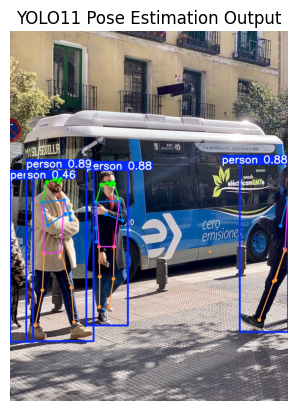

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO  # Assuming YOLO11 API is compatible

# Load the YOLO11 pose model
model = YOLO("yolo11n-pose.pt")  # Replace with the actual path if needed

# Run inference on a sample image (URL or local)
img_path = "https://ultralytics.com/images/bus.jpg"  # Replace as needed
results = model(img_path, task="pose")

# Show the result (keypoints overlaid on the image)
results[0].show()  # Opens a window

# Save and optionally display with matplotlib
output_path = Path("pose_output.jpg")
results[0].save(filename=output_path)

img = Image.open(output_path)
plt.imshow(img)
plt.axis("off")
plt.title("YOLO11 Pose Estimation Output")
plt.show()


In [1]:
import cv2
from ultralytics import YOLO

# Load YOLO11 pose model
model = YOLO("yolo11n-pose.pt")  # Use the correct path to your model

# Input and output video paths
input_video_path = "dance.mp4"
output_video_path = "output_pose.mp4"

# Open input video
cap = cv2.VideoCapture(input_video_path)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)

# Define output video writer
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Process video frame-by-frame
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Run pose estimation
    results = model(frame, task="pose", verbose=False)

    # Get the rendered frame with keypoints drawn
    annotated_frame = results[0].plot()

    # Write to output
    out.write(annotated_frame)

# Release everything
cap.release()
out.release()
print(f"Pose-estimated video saved to: {output_video_path}")


Pose-estimated video saved to: output_pose.mp4


In [11]:
import cv2
from ultralytics import YOLO

# Load the YOLO11 pose model
model = YOLO("yolo11n-pose.pt")  # Replace with your model path if needed

# Open the default webcam (0 = first camera)
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Cannot access camera.")
    exit()

# Process camera frames in real-time
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Run pose estimation
    results = model(frame, task="pose", verbose=False)

    # Draw keypoints and skeleton on the frame
    annotated_frame = results[0].plot()

    # Show the frame
    cv2.imshow("YOLO11 Pose Estimation", annotated_frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
cap.release()
cv2.destroyAllWindows()


In [3]:
import cv2
import numpy as np
from ultralytics import YOLO

# Load YOLO11 pose model
model = YOLO("yolo11n-pose.pt")  # Update with your model path if needed

# Load video
cap = cv2.VideoCapture("dance.mp4")
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)

# Define video writer to save output
out = cv2.VideoWriter("output_elbow_angle.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

# Function to compute angle between 3 points
def compute_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# Frame-by-frame processing
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Pose estimation
    results = model(frame, task="pose", verbose=False)
    annotated_frame = results[0].plot()

    # Extract keypoints for the first detected person
    if results[0].keypoints is not None and len(results[0].keypoints.xy) > 0:
        keypoints = results[0].keypoints.xy[0].cpu().numpy()  # shape: (17, 2)

        # Indices for left shoulder (5), left elbow (7), and left wrist (9)
        try:
            left_shoulder = keypoints[5]
            left_elbow = keypoints[7]
            left_wrist = keypoints[9]

            # Compute angle
            elbow_angle = compute_angle(left_shoulder, left_elbow, left_wrist)

            # Display angle on the video
            cv2.putText(annotated_frame,
                        f"Left Elbow Angle: {elbow_angle:.1f} deg",
                        (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 255, 0), 2)
        except IndexError:
            pass  # Missing keypoints

    # Write to output
    out.write(annotated_frame)

# Cleanup
cap.release()
out.release()
cv2.destroyAllWindows()
print("Saved to output_elbow_angle.mp4")


Saved to output_elbow_angle.mp4


In [4]:
import cv2
import numpy as np
from ultralytics import YOLO

# Load model
model = YOLO("yolo11n-pose.pt")

# Load video
cap = cv2.VideoCapture("dance.mp4")
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter("output_single_left_elbow_angle.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

def compute_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine, -1.0, 1.0))
    return np.degrees(angle)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame, task="pose", verbose=False)
    annotated_frame = results[0].plot()

    if results[0].keypoints is not None and len(results[0].keypoints.xy) > 0:
        keypoints = results[0].keypoints.xy[0].cpu().numpy()  # first person

        try:
            ls = keypoints[5]  # left shoulder
            le = keypoints[7]  # left elbow
            lw = keypoints[9]  # left wrist

            angle = compute_angle(ls, le, lw)
            position = tuple(le.astype(int))

            cv2.putText(annotated_frame,
                        f"Left_Elbow: {angle:.1f} deg",
                        position,
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, (0, 255, 255), 2)
        except IndexError:
            pass

    out.write(annotated_frame)

cap.release()
out.release()
cv2.destroyAllWindows()
print("Saved to output_single_elbow_angle.mp4")


Saved to output_single_elbow_angle.mp4


In [7]:
import cv2
import numpy as np
from ultralytics import YOLO

# Load pose model
model = YOLO("yolo11n-pose.pt")

# Open webcam
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Game box position
box_x = width // 2
box_y = height // 2
box_size = 50
speed = 10

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Run pose detection
    results = model(frame, task="pose", verbose=False)

    if results[0].keypoints is not None and len(results[0].keypoints.xy) > 0:
        # Get first person's keypoints
        keypoints = results[0].keypoints.xy[0].cpu().numpy()

        try:
            rw = keypoints[10]  # right wrist
            wrist_x = rw[0]

            # Move box
            if wrist_x > width * 0.6:
                box_x += speed
            elif wrist_x < width * 0.4:
                box_x -= speed

        except IndexError:
            pass

    # Clamp box inside screen
    box_x = max(0, min(box_x, width - box_size))

    # Draw webcam frame
    output = frame.copy()

    # Draw game box
    cv2.rectangle(output, (box_x, box_y), (box_x + box_size, box_y + box_size), (0, 255, 0), -1)

    # Show result
    cv2.imshow("Hand-Controlled Game", output)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
